In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Reshape, LeakyReLU, BatchNormalization, Concatenate, Lambda, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [28]:
from toImportFunc import load_data

In [29]:
# Define directories and file paths
dataset_directory = "dataset/"
testing_directory = dataset_directory + "/test"

embeddings_test_path = testing_directory + "/embeddings.pickle"
filenames_test_path = testing_directory + "/names.pickle"
class_info_test_path = testing_directory + "/class_info.pickle"

CUB_dataset_directory = "CUB_200_2011/CUB_200_2011"

In [30]:
# Load testing data
_, _, embeddings_test = load_data(filenames_path=filenames_test_path,
                                  class_info_path=class_info_test_path,
                                  dataset_directory=CUB_dataset_directory,
                                  embeddings_path=embeddings_test_path,
                                  img_size=(64, 64))


Embeddings shape: (2933, 10, 1024)
All embeddings shape: (2933, 10, 1024)


In [31]:
# Hyperparameters
image_size = 64
z_dim = 100
condition_dim = 128
embedding_dim = 1024

In [32]:
# Function to generate conditioning vector
def generate_c(x):
    mean = x[:, :condition_dim]
    log_sigma = x[:, condition_dim:]
    stddev = tf.exp(log_sigma)
    epsilon = tf.random.normal(shape=(tf.shape(mean)[1],))
    c = stddev * epsilon + mean
    return c

# Build the generator model
def build_generator():
    input_layer = Input(shape=(embedding_dim,))
    x = Dense(condition_dim * 2)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(x)
    c = Lambda(generate_c)(mean_logsigma)

    noise_input = Input(shape=(z_dim,))
    gen_input = Concatenate()([c, noise_input])

    x = Dense(128 * 8 * 4 * 4, use_bias=False)(gen_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((4, 4, 128 * 8))(x)

    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    output = Activation('tanh')(x)

    model = Model([input_layer, noise_input], output)
    return model


In [33]:
# Load the generator
generator = build_generator()
generator.load_weights('generator.h5')


/Users/devanshurana/Desktop/Projects/text_2_image-gan/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [34]:
def generate_and_display_image(embedding):
    z_noise = np.random.normal(0, 1, (1, z_dim))
    generated_img = generator.predict([embedding, z_noise])

    img = (generated_img[0] + 1) / 2  # Rescale to [0, 1]
    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


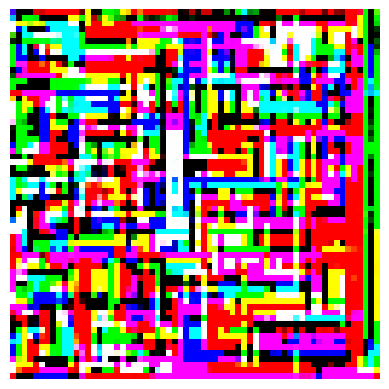

In [35]:
# Test the generator with one embedding
single_embedding = embeddings_test[0:1, :]  # Get one embedding
generate_and_display_image(single_embedding)
